In [1]:
model_name = 'lightgbm'
device = 'cpu'
min_samples_per_class = 5
n_classes = 3
n_frac = 0.005
n_trials_tpe = 10
plot_param_importances = False
timeout_tpe = 60
random_state = 42
n_jobs = -1

In [2]:
# Parameters
model_name = "xgboostrf"
device = "cpu"
min_samples_per_class = 5
n_classes = 34
n_frac = 0.1
n_trials_tpe = 1000
plot_param_importances = False
timeout_tpe = 3600
random_state = 42
n_jobs = -1


In [3]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# UTILS

In [4]:
def stratified_sample_df(df, stratify_col, frac, min_samples_per_class, random_state):
    grouped = df.groupby(stratify_col)
    sample = grouped.apply(
        lambda x: x.sample(
            n=max(min_samples_per_class, int(len(x) * frac)), 
            replace=len(x) < max(min_samples_per_class, int(len(x) * frac)),
            random_state=random_state
        )
    ).reset_index(drop=True)
    return sample

In [5]:
def build_classifier(extra_kwargs={}):
    clf = None
    if model_name in ['lgbm', 'lightgbm']:
        import lightgbm as lgb
        kwargs = {
            'device_type': device,
            'n_jobs': n_jobs,
            'objective': 'binary' if n_classes == 2 else 'multiclass',
            'random_state': random_state,
            'verbose': 1,
            **extra_kwargs
        }
        if n_classes > 2:
            kwargs['num_class'] = n_classes
        clf = lgb.LGBMClassifier(**kwargs)
    elif model_name in ['xgb', 'xgboost']:
        from xgboost import XGBClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBClassifier(**kwargs)
    elif model_name in ['xgbrf', 'xgboostrf']:
        from xgboost import XGBRFClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBRFClassifier(**kwargs)
    return clf

In [6]:
from collections import OrderedDict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def process_metrics(y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results = OrderedDict({
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Precision (Weighted)': precision_weighted,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'Recall (Weighted)': recall_weighted,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro,
        'F1 (Weighted)': f1_weighted
    })

    pprint(results, indent=4)

In [7]:
from sklearn.metrics import classification_report

def process_classification_report(y_test, y_pred):
    try:
        cr = classification_report(y_test, y_pred, digits=6, target_names=labels)
        print(cr)
    except Exception as e:
        print('Cloud not build/show classification report. Reason:', e)

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def process_confusion_matrix(y_test, y_pred):
    try:
        y_test_decoded = [index_to_label[label] for label in y_test]
        y_pred_decoded = [index_to_label[label] for label in y_pred]
        cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)
        cm = np.round(cm / 1000, 1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(values_format='g')
    except Exception as e:
        print('Cloud not build/show confusion matrix. Reason:', e)

In [9]:
import numpy as np

def value_counts_to_dict(array):
    unique, counts = np.unique(array, return_counts=True)
    value_counts_dict = dict(zip(unique, counts))
    return value_counts_dict

# STEP 1: DATA PREP

In [10]:
# %load_ext cudf.pandas
import numpy as np
import pandas as pd
from pprint import pprint

if n_classes == 3: # dummy dataset
    df_sample = pd.read_parquet('input/dummy.parquet')
else:
    df_sample = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_sample['label'], unique_values = df_sample['label'].factorize()

label_to_index = {value: i for i, value in enumerate(unique_values)}
index_to_label = {v: k for k, v in label_to_index.items()}
labels = list(label_to_index.keys())
pprint(label_to_index, indent=4)

{   'Backdoor_Malware': 28,
    'BenignTraffic': 12,
    'BrowserHijacking': 29,
    'CommandInjection': 25,
    'DDoS-ACK_Fragmentation': 14,
    'DDoS-HTTP_Flood': 23,
    'DDoS-ICMP_Flood': 2,
    'DDoS-ICMP_Fragmentation': 17,
    'DDoS-PSHACK_Flood': 9,
    'DDoS-RSTFINFlood': 0,
    'DDoS-SYN_Flood': 8,
    'DDoS-SlowLoris': 27,
    'DDoS-SynonymousIP_Flood': 6,
    'DDoS-TCP_Flood': 10,
    'DDoS-UDP_Flood': 11,
    'DDoS-UDP_Fragmentation': 20,
    'DNS_Spoofing': 19,
    'DictionaryBruteForce': 30,
    'DoS-HTTP_Flood': 16,
    'DoS-SYN_Flood': 4,
    'DoS-TCP_Flood': 1,
    'DoS-UDP_Flood': 3,
    'MITM-ArpSpoofing': 13,
    'Mirai-greeth_flood': 5,
    'Mirai-greip_flood': 15,
    'Mirai-udpplain': 7,
    'Recon-HostDiscovery': 24,
    'Recon-OSScan': 21,
    'Recon-PingSweep': 32,
    'Recon-PortScan': 18,
    'SqlInjection': 31,
    'Uploading_Attack': 33,
    'VulnerabilityScan': 26,
    'XSS': 22}


In [11]:
# not stratified df sampling (just to check)
df_sample['label'].sample(frac=n_frac, random_state=random_state).value_counts()

label
2     719277
11    541364
10    449555
9     408612
8     405906
0     404604
6     360036
3     331222
1     267964
4     202777
12    109844
5      99055
7      89251
15     75698
17     45342
13     30994
14     28637
20     28614
19     17843
24     13529
21      9921
18      8279
16      7318
26      3699
23      2860
27      2402
30      1267
29       619
25       557
31       521
22       369
28       337
32       249
33       136
Name: count, dtype: int64

In [12]:
# stratified df sampling
df_sample = stratified_sample_df(df_sample, 'label', n_frac, min_samples_per_class, random_state)

/tmp/ipykernel_3579468/2006267505.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = grouped.apply(


In [13]:
df_sample['label'].value_counts()

label
2     720050
11    541228
10    449766
9     409475
8     405919
0     404528
6     359813
3     331859
1     267144
4     202883
12    109819
5      99186
7      89057
15     75168
17     45248
13     30759
20     28692
14     28510
19     17891
24     13437
21      9825
18      8228
16      7186
26      3738
23      2879
27      2342
30      1306
29       585
25       540
31       524
22       384
28       321
32       226
33       125
Name: count, dtype: int64

In [14]:
X_sample = df_sample.drop('label', axis=1)

print(type(X_sample))
print(X_sample.shape)
print(X_sample.dtypes)

<class 'pandas.core.frame.DataFrame'>
(4668641, 46)
flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float32
HTTPS              float32
DNS                float32
Telnet             float32
SMTP               float32
SSH                float32
IRC                float32
TCP                float32
UDP                float32
DHCP               float32
ARP                float32
ICMP               float32
IPv                float32
LLC                float32
Tot sum            float32
Min                float32
Max

In [15]:
y_sample = df_sample['label']

print(type(y_sample))
print(y_sample.shape)
print(y_sample.dtype)
print(y_sample.unique())
print(y_sample.nunique())
y_sample.value_counts()

<class 'pandas.core.series.Series'>
(4668641,)
int64
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
34


label
2     720050
11    541228
10    449766
9     409475
8     405919
0     404528
6     359813
3     331859
1     267144
4     202883
12    109819
5      99186
7      89057
15     75168
17     45248
13     30759
20     28692
14     28510
19     17891
24     13437
21      9825
18      8228
16      7186
26      3738
23      2879
27      2342
30      1306
29       585
25       540
31       524
22       384
28       321
32       226
33       125
Name: count, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

# Split into 80% training+validation and 20% test
X_sample_train_val, X_sample_test, y_sample_train_val, y_sample_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=random_state, stratify=y_sample
)

# Split the 80% training+validation set into 75% training and 25% validation
X_sample_train, X_sample_val, y_sample_train, y_sample_val = train_test_split(
    X_sample_train_val, y_sample_train_val, test_size=0.25, random_state=random_state, stratify=y_sample_train_val
)

# Verify the sizes of the splits
print(f'Training   : {len(X_sample_train)}\t({(100.0 * len(X_sample_train) / len(X_sample)):.2f}) %\t{sorted(y_sample_train.unique())}')
print(f'Validation : {len(X_sample_val)}\t({(100.0 * len(X_sample_val) / len(X_sample)):.2f}) %\t{sorted(y_sample_val.unique())}')
print(f'Test       : {len(X_sample_test)}\t({(100.0 * len(X_sample_test) / len(X_sample)):.2f}) %\t{sorted(y_sample_test.unique())}')

Training   : 2801184	(60.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Validation : 933728	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Test       : 933729	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [17]:
assert sorted(y_sample_train.unique()) == sorted(y_sample_val.unique())
assert sorted(y_sample_train.unique()) == sorted(y_sample_test.unique())
assert sorted(y_sample_val.unique()) == sorted(y_sample_test.unique())

# STEP 2: PREPROCESSING & FEATURE SELECTION

### Preprocessing Methods

In [18]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler, StandardScaler

class DummyPreprocessor:
    def fit(self, _X, _y=None):
        return self
    def transform(self, _X):
        return _X

def make_preprocessor(pp_method):
    preprocessor = None
    if pp_method == 'none':
        preprocessor = DummyPreprocessor()
    if pp_method == 'maxabs':
        preprocessor = MaxAbsScaler()
    elif pp_method == 'minmax':
        preprocessor = MinMaxScaler()
    elif pp_method == 'norm':
        preprocessor = Normalizer()
    elif pp_method == 'robust':
        preprocessor = RobustScaler()
    elif pp_method == 'standard':
        preprocessor = StandardScaler()
    return preprocessor

### Feature Selection Methods

In [19]:
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE, BoostRFA

class DummyFeatureSelector:
    def fit(self, _X, _y, _eval_set=None):
        self.support_ = np.ones(_X.shape[1], dtype=bool)
        return self
    def transform(self, _X):
        return _X[:, self.support_]

def make_feature_selector(fs_method, fs_metric):
    feature_selector = None
    if fs_method == 'none':
        feature_selector = DummyFeatureSelector()
    elif fs_method == 'boruta':
        feature_selector = BoostBoruta(build_classifier(), importance_type=fs_metric, perc=100, sampling_seed=random_state)
    elif fs_method == 'rfa':
        feature_selector = BoostRFA(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    elif fs_method == 'rfe':
        feature_selector = BoostRFE(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    return feature_selector

### HPO

In [20]:
%%time

import optuna

from optuna.samplers import GridSampler

def objective(trial):

    try:
        # preprocessing hyperparameters
        pp_method = trial.suggest_categorical('pp_method', ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'])

        # feature selection hyperparameters
        fs_method = trial.suggest_categorical('fs_method', ['none', 'boruta', 'rfa', 'rfe'])
        fs_metric = trial.suggest_categorical('fs_metric', ['feature_importances', 'shap_importances'])
        
        # pipeline - preprocessing
        preprocessor = make_preprocessor(pp_method)
        preprocessor.fit(X_sample_train)
        X_sample_train_prep = pd.DataFrame(preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
        X_sample_val_prep = pd.DataFrame(preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
        X_sample_test_prep = pd.DataFrame(preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)
    
        # pipeline - feature selection
        feature_selector = make_feature_selector(fs_method, fs_metric)
        feature_selector.fit(X_sample_train_prep, y_sample_train, eval_set=[(X_sample_val_prep, y_sample_val)])
        selected_features = X_sample_train_prep.columns[feature_selector.support_]
        trial.set_user_attr('selected_features', selected_features)
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_prep[selected_features], y_sample_train)
        y_sample_pred = model.predict(X_sample_test_prep[selected_features])
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'pp_method': ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'],
    'fs_method': ['boruta', 'rfa', 'rfe'],
    'fs_metric': ['feature_importances', 'shap_importances']
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2024-07-22 12:22:16,769] A new study created in memory with name: no-name-85ac4972-096f-4c25-9182-e0554716c256


[I 2024-07-22 17:21:06,555] Trial 0 finished with value: 0.712383501585663 and parameters: {'pp_method': 'robust', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 0 with value: 0.712383501585663.


[I 2024-07-22 17:59:15,273] Trial 1 pruned. 


index 33 is out of bounds for axis 0 with size 12


[I 2024-07-22 19:55:50,765] Trial 2 finished with value: 0.7370410948173984 and parameters: {'pp_method': 'norm', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 2 with value: 0.7370410948173984.


[I 2024-07-22 20:17:12,328] Trial 3 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-22 22:54:37,176] Trial 4 finished with value: 0.70502998263908 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 2 with value: 0.7370410948173984.


[I 2024-07-22 23:35:20,785] Trial 5 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-23 00:27:48,739] Trial 6 finished with value: 0.706711164087387 and parameters: {'pp_method': 'maxabs', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 2 with value: 0.7370410948173984.


[I 2024-07-23 03:05:36,155] Trial 7 finished with value: 0.7117776890181249 and parameters: {'pp_method': 'standard', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 2 with value: 0.7370410948173984.


[I 2024-07-23 03:44:47,076] Trial 8 finished with value: 0.706711164087387 and parameters: {'pp_method': 'none', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 2 with value: 0.7370410948173984.


[I 2024-07-23 08:33:19,569] Trial 9 finished with value: 0.7359235388123191 and parameters: {'pp_method': 'norm', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 2 with value: 0.7370410948173984.


[I 2024-07-23 08:54:33,065] Trial 10 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-23 11:25:27,000] Trial 11 finished with value: 0.737333555748409 and parameters: {'pp_method': 'norm', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.737333555748409.


[I 2024-07-23 11:46:38,771] Trial 12 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-23 16:47:06,347] Trial 13 finished with value: 0.7046540716708832 and parameters: {'pp_method': 'none', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.737333555748409.


[I 2024-07-23 17:24:38,140] Trial 14 pruned. 


index 33 is out of bounds for axis 0 with size 12


[I 2024-07-23 17:46:20,768] Trial 15 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-23 18:27:48,873] Trial 16 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-23 18:49:04,669] Trial 17 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-23 21:25:45,137] Trial 18 finished with value: 0.7050081531565897 and parameters: {'pp_method': 'none', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.737333555748409.


[I 2024-07-24 02:23:00,843] Trial 19 finished with value: 0.7046540716708832 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.737333555748409.


[I 2024-07-24 03:04:23,086] Trial 20 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-24 03:47:49,221] Trial 21 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-24 04:28:46,574] Trial 22 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-24 07:06:35,134] Trial 23 finished with value: 0.7126106201758999 and parameters: {'pp_method': 'robust', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.737333555748409.


[I 2024-07-24 07:58:43,338] Trial 24 finished with value: 0.706711164087387 and parameters: {'pp_method': 'minmax', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.737333555748409.


[I 2024-07-24 08:38:42,313] Trial 25 pruned. 


index 24 is out of bounds for axis 0 with size 12


[I 2024-07-24 13:37:44,904] Trial 26 finished with value: 0.7046540716708832 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.737333555748409.


[I 2024-07-24 13:59:08,406] Trial 27 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-24 14:36:39,459] Trial 28 pruned. 


index 33 is out of bounds for axis 0 with size 12


[I 2024-07-24 15:17:53,554] Trial 29 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-24 15:55:54,926] Trial 30 pruned. 


index 33 is out of bounds for axis 0 with size 12


[I 2024-07-24 16:35:13,273] Trial 31 finished with value: 0.7130010501613965 and parameters: {'pp_method': 'standard', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.737333555748409.


[I 2024-07-24 21:32:22,696] Trial 32 finished with value: 0.7120263599777965 and parameters: {'pp_method': 'standard', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.737333555748409.


[I 2024-07-25 00:10:11,406] Trial 33 finished with value: 0.70502998263908 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.737333555748409.


[I 2024-07-25 00:47:52,858] Trial 34 pruned. 


index 33 is out of bounds for axis 0 with size 12


[I 2024-07-25 01:26:54,335] Trial 35 finished with value: 0.7133458531716865 and parameters: {'pp_method': 'robust', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.737333555748409.


CPU times: user 61d 18h 57min 13s, sys: 1h 34min 39s, total: 61d 20h 31min 52s
Wall time: 2d 13h 4min 37s


In [21]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.712384 2024-07-22 12:22:16.770354 2024-07-22 17:21:06.555178   
1        1       NaN 2024-07-22 17:21:06.556319 2024-07-22 17:59:15.272967   
2        2  0.737041 2024-07-22 17:59:15.273643 2024-07-22 19:55:50.764848   
3        3       NaN 2024-07-22 19:55:50.765894 2024-07-22 20:17:12.328094   
4        4  0.705030 2024-07-22 20:17:12.328973 2024-07-22 22:54:37.176367   
5        5       NaN 2024-07-22 22:54:37.177220 2024-07-22 23:35:20.785578   
6        6  0.706711 2024-07-22 23:35:20.786462 2024-07-23 00:27:48.739665   
7        7  0.711778 2024-07-23 00:27:48.740534 2024-07-23 03:05:36.155240   
8        8  0.706711 2024-07-23 03:05:36.156119 2024-07-23 03:44:47.076728   
9        9  0.735924 2024-07-23 03:44:47.077759 2024-07-23 08:33:19.569088   
10      10       NaN 2024-07-23 08:33:19.570172 2024-07-23 08:54:33.065868   
11      11  0.737334 2024-07-23 08:54:33.066411 2024-07-23 11:25:27.000388   
12      12       NaN 2024-07-23 11:25:27.001434 2024-07-23 11:46:38.771879   
13      13  0.704654 2024-07-23 11:46:38.772450 2024-07-23 16:47:06.347525   
14      14       NaN 2024-07-23 16:47:06.348406 2024-07-23 17:24:38.140109   
15      15       NaN 2024-07-23 17:24:38.140674 2024-07-23 17:46:20.768036   
16      16       NaN 2024-07-23 17:46:20.768930 2024-07-23 18:27:48.872943   
17      17       NaN 2024-07-23 18:27:48.873768 2024-07-23 18:49:04.669832   
18      18  0.705008 2024-07-23 18:49:04.670681 2024-07-23 21:25:45.137601   
19      19  0.704654 2024-07-23 21:25:45.138568 2024-07-24 02:23:00.843326   
20      20       NaN 2024-07-24 02:23:00.844184 2024-07-24 03:04:23.086382   
21      21       NaN 2024-07-24 03:04:23.087187 2024-07-24 03:47:49.221226   
22      22       NaN 2024-07-24 03:47:49.222145 2024-07-24 04:28:46.574033   
23      23  0.712611 2024-07-24 04:28:46.574841 2024-07-24 07:06:35.134702   
24      24  0.706711 2024-07-24 07:06:35.135791 2024-07-24 07:58:43.337853   
25      25       NaN 2024-07-24 07:58:43.338939 2024-07-24 08:38:42.313063   
26      26  0.704654 2024-07-24 08:38:42.313962 2024-07-24 13:37:44.904005   
27      27       NaN 2024-07-24 13:37:44.905105 2024-07-24 13:59:08.406563   
28      28       NaN 2024-07-24 13:59:08.407467 2024-07-24 14:36:39.459815   
29      29       NaN 2024-07-24 14:36:39.460528 2024-07-24 15:17:53.554159   
30      30       NaN 2024-07-24 15:17:53.554945 2024-07-24 15:55:54.926020   
31      31  0.713001 2024-07-24 15:55:54.926721 2024-07-24 16:35:13.272822   
32      32  0.712026 2024-07-24 16:35:13.273889 2024-07-24 21:32:22.696126   
33      33  0.705030 2024-07-24 21:32:22.697165 2024-07-25 00:10:11.406359   
34      34       NaN 2024-07-25 00:10:11.407202 2024-07-25 00:47:52.858359   
35      35  0.713346 2024-07-25 00:47:52.859095 2024-07-25 01:26:54.335109   

                 duration params_fs_method     params_fs_metric  \
0  0 days 04:58:49.784824              rfa  feature_importances   
1  0 days 00:38:08.716648              rfe     shap_importances   
2  0 days 01:56:35.491205           boruta  feature_importances   
3  0 days 00:21:21.562200           boruta     shap_importances   
4  0 days 02:37:24.847394              rfe  feature_importances   
5  0 days 00:40:43.608358              rfa     shap_importances   
6  0 days 00:52:27.953203           boruta  feature_importances   
7  0 days 02:37:47.414706              rfe  feature_importances   
8  0 days 00:39:10.920609           boruta  feature_importances   
9  0 days 04:48:32.491329              rfa  feature_importances   
10 0 days 00:21:13.495696           boruta     shap_importances   
11 0 days 02:30:53.933977              rfe  feature_importances   
12 0 days 00:21:11.770445           boruta     shap_importances   
13 0 days 05:00:27.575075              rfa  feature_importances   
14 0 days 00:37:31.791703              rfe     shap_importances   
15 0 days 00:21:42.627362           boruta   

In [22]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [23]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [24]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [25]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

[W 2024-07-25 01:26:55,336] Param fs_metric unique value length is less than 2.


[W 2024-07-25 01:26:55,337] Param fs_metric unique value length is less than 2.


[W 2024-07-25 01:26:55,337] Param fs_metric unique value length is less than 2.


[W 2024-07-25 01:26:55,337] Param fs_metric unique value length is less than 2.


In [26]:
best_preprocessor = make_preprocessor(study.best_trial.params['pp_method'])
best_preprocessor.fit(X_sample_train)
X_sample_train = pd.DataFrame(best_preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
X_sample_val = pd.DataFrame(best_preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
X_sample_test = pd.DataFrame(best_preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)

best_selected_features = study.best_trial.user_attrs['selected_features']
X_sample_train = X_sample_train[best_selected_features]
X_sample_val = X_sample_val[best_selected_features]
X_sample_test = X_sample_test[best_selected_features]

# STEP 3: DATA BALANCING

### Oversampling

In [27]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.over_sampling import *

def build_oversampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_generate = {
            class_: perfectly_balanced_occurences - occ
                    if occ < perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_generate = {
            class_: int(min(occ * threshold, perfectly_balanced_occurences - occ))
            if occ < perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_generate

def patch_oversampling_strategy(value_counts, n_generate):
    return {k : (value_counts[k] + n_generate[k]) for k in value_counts.keys()}

def make_over_sampler(over_strategy):
    over_sampler = RandomOverSampler(
        random_state=random_state, sampling_strategy=over_strategy)
    return over_sampler

### Undersampling

In [28]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.under_sampling import *

def build_undersampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_remove = {
            class_: occ - perfectly_balanced_occurences
                    if occ > perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_remove = {
            class_: int(min(occ * threshold, occ - perfectly_balanced_occurences))
            if occ > perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_remove

def patch_undersampling_strategy(value_counts, n_remove):
    return {k : (value_counts[k] - n_remove[k]) for k in value_counts.keys()}

def make_under_sampler(under_strategy):
    under_sampler = RandomUnderSampler(
        random_state=random_state, sampling_strategy=under_strategy)
    return under_sampler

### Combination

In [29]:
def fit_resample(_X_train, _y_train, over_thresh, under_thresh):

    _X_names = _X_train.columns.tolist()
    _y_name = _y_train.name
    
    _X_train_copy = _X_train.copy()
    _y_train_copy = _y_train.copy()

    if over_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_generate = build_oversampling_strategy(value_counts, over_thresh)
        over_strategy = patch_oversampling_strategy(value_counts, n_generate)
        over_sampler = make_over_sampler(over_strategy)
        _X_train_copy, _y_train_copy = over_sampler.fit_resample(_X_train_copy, _y_train_copy)

    if under_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_remove = build_undersampling_strategy(value_counts, under_thresh)
        under_strategy = patch_undersampling_strategy(value_counts, n_remove)
        under_sampler = make_under_sampler(under_strategy)
        _X_train_copy, _y_train_copy = under_sampler.fit_resample(_X_train_copy, _y_train_copy)

    return pd.DataFrame(_X_train_copy, columns=_X_names), pd.Series(_y_train_copy, name=_y_name)

### HPO

In [30]:
from itertools import chain

over_threshold_choices = list(chain(*[np.linspace(0, 4, num=17).round(2), ['auto']]))
under_threshold_choices = list(chain(*[np.linspace(0, 0.95, num=20).round(2), ['auto']]))

In [31]:
%%time
def objective(trial):

    try:
        # data balancing hyperparameters
        over_threshold = trial.suggest_categorical('over_threshold', over_threshold_choices)
        under_threshold = trial.suggest_categorical('under_threshold', under_threshold_choices)
    
        # pipeline - data balancing
        X_sample_train_bal, y_sample_train_bal = fit_resample(
            X_sample_train, y_sample_train, over_threshold, under_threshold
        )
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_bal, y_sample_train_bal)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)

    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'over_threshold': over_threshold_choices,
    'under_threshold': under_threshold_choices
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2024-07-25 01:26:56,886] A new study created in memory with name: no-name-f5720eac-2fb0-4be3-84b7-2241b99eb2e1


[I 2024-07-25 01:29:22,602] Trial 0 finished with value: 0.7769527115333934 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.6}. Best is trial 0 with value: 0.7769527115333934.


[I 2024-07-25 01:31:41,082] Trial 1 finished with value: 0.7971177671525481 and parameters: {'over_threshold': 4.0, 'under_threshold': 'auto'}. Best is trial 1 with value: 0.7971177671525481.


[I 2024-07-25 01:33:36,382] Trial 2 finished with value: 0.7836426861326313 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.9}. Best is trial 1 with value: 0.7971177671525481.


[I 2024-07-25 01:36:23,795] Trial 3 finished with value: 0.7656079151216177 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.2}. Best is trial 1 with value: 0.7971177671525481.


[I 2024-07-25 01:39:09,904] Trial 4 finished with value: 0.8182073523824158 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.4}. Best is trial 4 with value: 0.8182073523824158.


[I 2024-07-25 01:42:11,405] Trial 5 finished with value: 0.8032261995965166 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.15}. Best is trial 4 with value: 0.8182073523824158.


[I 2024-07-25 01:45:02,588] Trial 6 finished with value: 0.7712580014320745 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.15}. Best is trial 4 with value: 0.8182073523824158.


[I 2024-07-25 01:47:40,197] Trial 7 finished with value: 0.7986695942535904 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.45}. Best is trial 4 with value: 0.8182073523824158.


[I 2024-07-25 01:49:49,430] Trial 8 finished with value: 0.7931297501006006 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.9}. Best is trial 4 with value: 0.8182073523824158.


[I 2024-07-25 01:51:55,097] Trial 9 finished with value: 0.7976329854520927 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.75}. Best is trial 4 with value: 0.8182073523824158.


[I 2024-07-25 01:53:45,894] Trial 10 finished with value: 0.7678061281403736 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.95}. Best is trial 4 with value: 0.8182073523824158.


[I 2024-07-25 01:56:32,809] Trial 11 finished with value: 0.7971380586819995 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.3}. Best is trial 4 with value: 0.8182073523824158.


[I 2024-07-25 02:00:03,332] Trial 12 finished with value: 0.7731112354539391 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.0}. Best is trial 4 with value: 0.8182073523824158.


[I 2024-07-25 02:02:29,499] Trial 13 finished with value: 0.769483557281217 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.5}. Best is trial 4 with value: 0.8182073523824158.


[I 2024-07-25 02:05:44,084] Trial 14 finished with value: 0.7898665818717542 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.0}. Best is trial 4 with value: 0.8182073523824158.


[I 2024-07-25 02:07:12,243] Trial 15 finished with value: 0.7528237575327591 and parameters: {'over_threshold': 0.0, 'under_threshold': 'auto'}. Best is trial 4 with value: 0.8182073523824158.


[I 2024-07-25 02:09:57,303] Trial 16 finished with value: 0.7667490589306869 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.25}. Best is trial 4 with value: 0.8182073523824158.


[I 2024-07-25 02:12:13,277] Trial 17 finished with value: 0.8215298791242753 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.7}. Best is trial 17 with value: 0.8215298791242753.


[I 2024-07-25 02:14:24,048] Trial 18 finished with value: 0.7956738338492667 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.8}. Best is trial 17 with value: 0.8215298791242753.


[I 2024-07-25 02:17:02,963] Trial 19 finished with value: 0.7738107162343788 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.35}. Best is trial 17 with value: 0.8215298791242753.


[I 2024-07-25 02:19:14,804] Trial 20 finished with value: 0.7711633698780848 and parameters: {'over_threshold': 3.5, 'under_threshold': 'auto'}. Best is trial 17 with value: 0.8215298791242753.


[I 2024-07-25 02:21:37,937] Trial 21 finished with value: 0.7909063345752034 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.65}. Best is trial 17 with value: 0.8215298791242753.


[I 2024-07-25 02:24:27,415] Trial 22 finished with value: 0.7311642641966971 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.1}. Best is trial 17 with value: 0.8215298791242753.


[I 2024-07-25 02:27:39,015] Trial 23 finished with value: 0.7467806615510986 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.6}. Best is trial 17 with value: 0.8215298791242753.


[I 2024-07-25 02:29:55,735] Trial 24 finished with value: 0.7958239491226562 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.65}. Best is trial 17 with value: 0.8215298791242753.


[I 2024-07-25 02:32:05,177] Trial 25 finished with value: 0.7931297501006006 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.85}. Best is trial 17 with value: 0.8215298791242753.


[I 2024-07-25 02:34:11,504] Trial 26 finished with value: 0.7839131590755518 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.85}. Best is trial 17 with value: 0.8215298791242753.


[I 2024-07-25 02:36:39,995] Trial 27 finished with value: 0.7786119140601441 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.35}. Best is trial 17 with value: 0.8215298791242753.


[I 2024-07-25 02:38:58,891] Trial 28 finished with value: 0.7971177671525481 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.85}. Best is trial 17 with value: 0.8215298791242753.


[I 2024-07-25 02:42:10,056] Trial 29 finished with value: 0.7764040667817527 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.0}. Best is trial 17 with value: 0.8215298791242753.


[I 2024-07-25 02:43:53,624] Trial 30 finished with value: 0.7840159521536552 and parameters: {'over_threshold': 0.5, 'under_threshold': 'auto'}. Best is trial 17 with value: 0.8215298791242753.


[I 2024-07-25 02:46:22,456] Trial 31 finished with value: 0.752786580108527 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.3}. Best is trial 17 with value: 0.8215298791242753.


[I 2024-07-25 02:48:39,840] Trial 32 finished with value: 0.7971177671525481 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.95}. Best is trial 17 with value: 0.8215298791242753.


[I 2024-07-25 02:51:27,157] Trial 33 finished with value: 0.7790719111049548 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.3}. Best is trial 17 with value: 0.8215298791242753.


[I 2024-07-25 02:54:13,825] Trial 34 finished with value: 0.8262463242186385 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.35}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 02:56:07,134] Trial 35 finished with value: 0.7733006910495748 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.7}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 02:59:03,592] Trial 36 finished with value: 0.7756127370717175 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:01:53,520] Trial 37 finished with value: 0.7671026504774487 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.2}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:04:07,862] Trial 38 finished with value: 0.7711633698780848 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.9}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:06:12,385] Trial 39 finished with value: 0.7849577185776078 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.6}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:08:47,199] Trial 40 finished with value: 0.7827799778310345 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.4}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:11:39,743] Trial 41 finished with value: 0.7944143176340992 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.25}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:14:27,298] Trial 42 finished with value: 0.8015337584158874 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.35}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:16:33,624] Trial 43 finished with value: 0.793647887147821 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.7}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:19:47,434] Trial 44 finished with value: 0.7888279205740204 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.0}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:22:43,888] Trial 45 finished with value: 0.7797349734545247 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:25:57,058] Trial 46 finished with value: 0.7474600349570043 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.5}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:28:53,658] Trial 47 finished with value: 0.7821969267114002 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.1}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:32:08,132] Trial 48 finished with value: 0.7479123162693366 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.9}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:35:33,965] Trial 49 finished with value: 0.7473102152853711 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.25}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:38:32,095] Trial 50 finished with value: 0.7735173527710181 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.15}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:41:35,700] Trial 51 finished with value: 0.8002873426294782 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.15}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:43:04,012] Trial 52 finished with value: 0.7528237575327591 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.85}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:45:56,490] Trial 53 finished with value: 0.8206212304891037 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.3}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:49:23,849] Trial 54 finished with value: 0.7472405800321225 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.2}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:52:29,709] Trial 55 finished with value: 0.7506020059475396 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.0}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:54:01,175] Trial 56 finished with value: 0.78276151173472 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.7}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:55:55,393] Trial 57 finished with value: 0.7946933659662488 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.75}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 03:59:08,157] Trial 58 finished with value: 0.7975200814524245 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.0}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:01:33,973] Trial 59 finished with value: 0.7820919447585146 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.45}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:04:29,039] Trial 60 finished with value: 0.7478750138761627 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:06:35,831] Trial 61 finished with value: 0.7839131590755518 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.8}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:08:31,201] Trial 62 finished with value: 0.7836426861326313 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.8}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:10:32,081] Trial 63 finished with value: 0.7672215795511285 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.95}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:13:47,602] Trial 64 finished with value: 0.7479123162693366 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.8}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:16:06,034] Trial 65 finished with value: 0.7781593321203693 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.85}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:19:06,179] Trial 66 finished with value: 0.7835360327482582 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:21:06,758] Trial 67 finished with value: 0.7726560940594553 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.65}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:23:52,162] Trial 68 finished with value: 0.7667578687302794 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.25}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:27:26,421] Trial 69 finished with value: 0.7439030933488371 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.15}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:29:59,287] Trial 70 finished with value: 0.7752191346049532 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.35}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:32:59,800] Trial 71 finished with value: 0.7475069619404996 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.1}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:35:26,541] Trial 72 finished with value: 0.7891341346268411 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.45}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:38:25,906] Trial 73 finished with value: 0.7746691088903667 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:40:37,976] Trial 74 finished with value: 0.7827095183139386 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.7}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:42:58,876] Trial 75 finished with value: 0.7664332355240501 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.45}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:45:20,720] Trial 76 finished with value: 0.7566883033562578 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.3}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:47:32,189] Trial 77 finished with value: 0.7985780054432469 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.65}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:49:43,961] Trial 78 finished with value: 0.7918961870981095 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.65}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:52:14,417] Trial 79 finished with value: 0.8044687008815099 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.5}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:54:26,137] Trial 80 finished with value: 0.7964210348159718 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.75}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 04:57:39,522] Trial 81 finished with value: 0.7479123162693366 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.75}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:00:39,361] Trial 82 finished with value: 0.775139802455831 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.45}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:02:50,687] Trial 83 finished with value: 0.7770674004095345 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.65}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:04:41,102] Trial 84 finished with value: 0.7720845429633016 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.85}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:07:30,994] Trial 85 finished with value: 0.7864991024182292 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.3}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:10:00,611] Trial 86 finished with value: 0.7948293410695749 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:12:12,554] Trial 87 finished with value: 0.7849865356818704 and parameters: {'over_threshold': 3.0, 'under_threshold': 'auto'}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:14:33,182] Trial 88 finished with value: 0.7753876151917823 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.7}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:16:29,741] Trial 89 finished with value: 0.7894747719079704 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.7}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:19:26,765] Trial 90 finished with value: 0.7713885925280751 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:22:11,275] Trial 91 finished with value: 0.7992137294383975 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.35}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:25:24,925] Trial 92 finished with value: 0.7479123162693366 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.7}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:28:35,083] Trial 93 finished with value: 0.7479123162693366 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.85}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:30:24,281] Trial 94 finished with value: 0.7720845429633016 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.9}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:32:41,486] Trial 95 finished with value: 0.7971177671525481 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.9}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:35:40,465] Trial 96 finished with value: 0.7867987703097159 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.1}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:37:37,902] Trial 97 finished with value: 0.7776657308596171 and parameters: {'over_threshold': 1.25, 'under_threshold': 'auto'}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:41:00,727] Trial 98 finished with value: 0.7471041757498696 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.45}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:43:12,119] Trial 99 finished with value: 0.8016881226001016 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.85}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:46:25,330] Trial 100 finished with value: 0.7479123162693366 and parameters: {'over_threshold': 'auto', 'under_threshold': 'auto'}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:49:18,915] Trial 101 finished with value: 0.7996850523402106 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.25}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:51:32,046] Trial 102 finished with value: 0.7849865356818704 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.95}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:53:21,712] Trial 103 finished with value: 0.7637401586130532 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:56:34,038] Trial 104 finished with value: 0.7475177500644383 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.65}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 05:59:29,511] Trial 105 finished with value: 0.804633857171492 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.2}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:00:56,585] Trial 106 finished with value: 0.7528237575327591 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.95}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:03:28,181] Trial 107 finished with value: 0.7752788466562721 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.5}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:05:35,687] Trial 108 finished with value: 0.7913890954774621 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.85}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:08:35,976] Trial 109 finished with value: 0.7940809642738854 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.1}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:10:56,645] Trial 110 finished with value: 0.7798885006724803 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:13:54,981] Trial 111 finished with value: 0.7647248521569053 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.1}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:16:45,988] Trial 112 finished with value: 0.7705811254505006 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.25}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:18:23,707] Trial 113 finished with value: 0.7637555606070965 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.8}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:20:44,887] Trial 114 finished with value: 0.7635177411067708 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.45}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:24:02,505] Trial 115 finished with value: 0.7994989074236991 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.15}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:26:17,494] Trial 116 finished with value: 0.7811971294558807 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.7}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:29:24,734] Trial 117 finished with value: 0.7633151960861793 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.0}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:31:18,788] Trial 118 finished with value: 0.7782021722078053 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.7}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:33:46,034] Trial 119 finished with value: 0.7769221922793704 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.5}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:35:50,202] Trial 120 finished with value: 0.7816750264250051 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.75}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:37:48,545] Trial 121 finished with value: 0.7821607433889768 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.75}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:41:28,862] Trial 122 finished with value: 0.7501748438560242 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:44:22,657] Trial 123 finished with value: 0.7817151934405427 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.2}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:47:02,936] Trial 124 finished with value: 0.7784861319939801 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.3}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:49:11,340] Trial 125 finished with value: 0.7905268856970791 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.6}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:50:48,354] Trial 126 finished with value: 0.7685158284683542 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.65}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:54:01,042] Trial 127 finished with value: 0.7660025382295175 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.0}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:56:44,405] Trial 128 finished with value: 0.794357225323389 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.4}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 06:59:30,483] Trial 129 finished with value: 0.7918375168261759 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.35}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:01:20,909] Trial 130 finished with value: 0.7720845429633016 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.95}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:03:52,920] Trial 131 finished with value: 0.781868636787973 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.45}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:05:22,610] Trial 132 finished with value: 0.7535030640196636 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.8}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:08:16,237] Trial 133 finished with value: 0.7844847949250524 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.2}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:10:07,824] Trial 134 finished with value: 0.7678061281403736 and parameters: {'over_threshold': 1.0, 'under_threshold': 'auto'}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:12:18,952] Trial 135 finished with value: 0.7730535086326265 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.6}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:14:30,392] Trial 136 finished with value: 0.8016881226001016 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.9}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:16:50,416] Trial 137 finished with value: 0.7781593321203693 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.8}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:20:08,629] Trial 138 finished with value: 0.7458372438940961 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.4}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:23:17,912] Trial 139 finished with value: 0.7827906077587438 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.0}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:25:05,898] Trial 140 finished with value: 0.7720845429633016 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.8}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:27:08,041] Trial 141 finished with value: 0.7580816134047218 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.45}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:30:08,905] Trial 142 finished with value: 0.737333555748409 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.0}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:31:55,101] Trial 143 finished with value: 0.7571230787130174 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.65}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:34:36,972] Trial 144 finished with value: 0.7662428638005199 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.35}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:37:45,269] Trial 145 finished with value: 0.783508120382885 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.25}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:40:08,511] Trial 146 finished with value: 0.7617030584618258 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.35}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:41:44,789] Trial 147 finished with value: 0.7640901290607494 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.85}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:43:39,811] Trial 148 finished with value: 0.7743776772889163 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.65}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:45:53,718] Trial 149 finished with value: 0.7611723250750134 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.45}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:48:12,560] Trial 150 finished with value: 0.7781593321203693 and parameters: {'over_threshold': 3.75, 'under_threshold': 'auto'}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:51:10,466] Trial 151 finished with value: 0.7789934545039818 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.1}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:52:59,367] Trial 152 finished with value: 0.7720845429633016 and parameters: {'over_threshold': 0.75, 'under_threshold': 'auto'}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:55:32,222] Trial 153 finished with value: 0.8074899224297291 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.4}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 07:58:06,524] Trial 154 finished with value: 0.8052951140412665 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.4}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:01:14,958] Trial 155 finished with value: 0.7559268796652535 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.0}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:03:10,736] Trial 156 finished with value: 0.7776657308596171 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.8}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:06:00,536] Trial 157 finished with value: 0.7826915672725436 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.25}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:08:02,733] Trial 158 finished with value: 0.7672215795511285 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.8}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:09:43,667] Trial 159 finished with value: 0.7804580455088024 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.75}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:12:37,095] Trial 160 finished with value: 0.7534181249516865 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.15}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:15:36,022] Trial 161 finished with value: 0.774407709353257 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.1}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:17:55,444] Trial 162 finished with value: 0.7781593321203693 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.95}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:20:49,903] Trial 163 finished with value: 0.7613161628207715 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.2}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:23:01,174] Trial 164 finished with value: 0.7956738338492667 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.95}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:25:40,055] Trial 165 finished with value: 0.7717822559392071 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.4}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:28:20,493] Trial 166 finished with value: 0.7860977021522595 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.3}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:30:54,854] Trial 167 finished with value: 0.8043250404072084 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.5}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:33:52,932] Trial 168 finished with value: 0.7612207455875185 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.15}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:36:11,554] Trial 169 finished with value: 0.784063853904983 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.65}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:38:48,341] Trial 170 finished with value: 0.7561350984366122 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.2}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:40:30,167] Trial 171 finished with value: 0.7640901290607494 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.95}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:43:24,278] Trial 172 finished with value: 0.7879569213534316 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.2}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:45:45,790] Trial 173 finished with value: 0.7955460296206112 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.65}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:48:03,134] Trial 174 finished with value: 0.8001000807118777 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.75}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:51:28,877] Trial 175 finished with value: 0.7485158968386758 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.3}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:54:10,183] Trial 176 finished with value: 0.7378323652227304 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.2}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:56:32,642] Trial 177 finished with value: 0.7998947114663096 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.5}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 08:59:00,396] Trial 178 finished with value: 0.8077497250267529 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:01:46,347] Trial 179 finished with value: 0.7633275920334653 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.2}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:03:28,480] Trial 180 finished with value: 0.7619693313374982 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.6}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:05:40,983] Trial 181 finished with value: 0.7711633698780848 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.85}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:08:42,768] Trial 182 finished with value: 0.7765618741654987 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:11:03,113] Trial 183 finished with value: 0.8061561776712446 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:13:08,701] Trial 184 finished with value: 0.8026046352491056 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.65}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:16:16,069] Trial 185 finished with value: 0.7590304475264273 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.0}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:17:51,406] Trial 186 finished with value: 0.7640901290607494 and parameters: {'over_threshold': 0.25, 'under_threshold': 'auto'}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:20:03,811] Trial 187 finished with value: 0.8128365498804574 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.75}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:22:18,470] Trial 188 finished with value: 0.779029458027743 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.6}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:24:45,911] Trial 189 finished with value: 0.786941659796705 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.45}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:26:57,627] Trial 190 finished with value: 0.7849865356818704 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.8}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:29:11,897] Trial 191 finished with value: 0.7987269450278486 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:31:02,176] Trial 192 finished with value: 0.7678061281403736 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.85}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:33:50,879] Trial 193 finished with value: 0.7813611319398863 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.3}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:35:47,385] Trial 194 finished with value: 0.7684520961436777 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.5}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:38:02,500] Trial 195 finished with value: 0.7867263337197369 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.7}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:41:02,421] Trial 196 finished with value: 0.7751913010655552 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.15}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:43:31,124] Trial 197 finished with value: 0.7872378600411095 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.4}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:45:44,163] Trial 198 finished with value: 0.7849865356818704 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.9}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:48:24,710] Trial 199 finished with value: 0.7818295891769833 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.35}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:51:18,208] Trial 200 finished with value: 0.7929077416932232 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.25}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:54:17,751] Trial 201 finished with value: 0.766946386304924 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.1}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:57:28,296] Trial 202 finished with value: 0.7843625994597057 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.0}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 09:59:48,779] Trial 203 finished with value: 0.800641991476673 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.65}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:02:02,632] Trial 204 finished with value: 0.7748229778193416 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.5}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:04:18,595] Trial 205 finished with value: 0.7637605803000227 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.4}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:07:26,873] Trial 206 finished with value: 0.7850876069990081 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.0}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:10:19,979] Trial 207 finished with value: 0.7772157503039905 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.2}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:12:29,578] Trial 208 finished with value: 0.7956738338492667 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.85}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:14:23,970] Trial 209 finished with value: 0.7836426861326313 and parameters: {'over_threshold': 1.5, 'under_threshold': 'auto'}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:17:14,307] Trial 210 finished with value: 0.7812121978106703 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.15}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:19:53,237] Trial 211 finished with value: 0.7641789331978353 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.35}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:22:01,967] Trial 212 finished with value: 0.7934847101374087 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:24:45,297] Trial 213 finished with value: 0.7664130211240104 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.3}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:26:53,267] Trial 214 finished with value: 0.7993255769327724 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.75}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:29:05,869] Trial 215 finished with value: 0.7711633698780848 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.8}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:32:05,662] Trial 216 finished with value: 0.7980967396720193 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.2}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:34:19,172] Trial 217 finished with value: 0.8016881226001016 and parameters: {'over_threshold': 3.25, 'under_threshold': 'auto'}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:36:59,756] Trial 218 finished with value: 0.7868609345281933 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.45}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:39:10,849] Trial 219 finished with value: 0.7956738338492667 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.9}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:41:11,092] Trial 220 finished with value: 0.7836426861326313 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.85}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:44:25,375] Trial 221 finished with value: 0.7471609106929623 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:46:41,638] Trial 222 finished with value: 0.7801500893818628 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:48:49,784] Trial 223 finished with value: 0.7931297501006006 and parameters: {'over_threshold': 2.5, 'under_threshold': 'auto'}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:50:18,884] Trial 224 finished with value: 0.7528237575327591 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.9}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:52:58,391] Trial 225 finished with value: 0.7802632043128607 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.3}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:55:25,309] Trial 226 finished with value: 0.7929319730204347 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.6}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 10:58:36,041] Trial 227 finished with value: 0.7632385317540096 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.0}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:00:56,234] Trial 228 finished with value: 0.80194408184615 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.6}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:03:20,285] Trial 229 finished with value: 0.7634494564413894 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.35}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:05:56,322] Trial 230 finished with value: 0.7733540597029435 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.45}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:07:47,082] Trial 231 finished with value: 0.7678061281403736 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.8}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:11:26,164] Trial 232 finished with value: 0.7462849545318813 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.1}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:13:52,895] Trial 233 finished with value: 0.7807380407120492 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.5}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:16:42,010] Trial 234 finished with value: 0.7616432298503351 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.15}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:18:58,141] Trial 235 finished with value: 0.791279719693314 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.6}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:21:59,454] Trial 236 finished with value: 0.8057254526006591 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.15}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:25:00,475] Trial 237 finished with value: 0.7933140619921817 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:26:55,797] Trial 238 finished with value: 0.7636790915221019 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.6}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:28:27,833] Trial 239 finished with value: 0.7616360481282406 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.75}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:30:40,487] Trial 240 finished with value: 0.8016881226001016 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.8}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:33:24,845] Trial 241 finished with value: 0.7707345603770087 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.25}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:36:11,268] Trial 242 finished with value: 0.7762376400621426 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.35}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:38:29,035] Trial 243 finished with value: 0.7660922200400322 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.5}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:41:52,864] Trial 244 finished with value: 0.7475774827829893 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.35}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:43:40,168] Trial 245 finished with value: 0.761639359632853 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.7}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:45:49,085] Trial 246 finished with value: 0.7931297501006006 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.8}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:48:41,801] Trial 247 finished with value: 0.7830987708724033 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.15}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:50:55,253] Trial 248 finished with value: 0.7942799530005407 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.6}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:53:12,772] Trial 249 finished with value: 0.785655242837886 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.75}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:56:09,208] Trial 250 finished with value: 0.7865705222980898 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.2}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 11:58:22,769] Trial 251 finished with value: 0.7905978326941523 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.7}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:02:42,217] Trial 252 finished with value: 0.7666890062422723 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.1}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:06:27,197] Trial 253 finished with value: 0.799523335977427 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:09:20,638] Trial 254 finished with value: 0.7515927715940509 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:11:22,547] Trial 255 finished with value: 0.7851056016160736 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.7}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:14:15,335] Trial 256 finished with value: 0.7799139072784845 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.3}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:16:00,771] Trial 257 finished with value: 0.7619065847885317 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.75}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:18:51,694] Trial 258 finished with value: 0.7967297898599507 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.3}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:21:51,720] Trial 259 finished with value: 0.7600689326543977 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:24:51,251] Trial 260 finished with value: 0.7642071813870425 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:27:44,837] Trial 261 finished with value: 0.7834014652038415 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.25}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:29:28,795] Trial 262 finished with value: 0.7840159521536552 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.85}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:32:09,364] Trial 263 finished with value: 0.7742687855325109 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.35}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:35:22,584] Trial 264 finished with value: 0.7479123162693366 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.95}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:37:41,662] Trial 265 finished with value: 0.7781593321203693 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.9}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:39:59,718] Trial 266 finished with value: 0.7775490329010591 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.5}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:42:58,680] Trial 267 finished with value: 0.7914116497977775 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.25}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:45:57,015] Trial 268 finished with value: 0.7820176235618974 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.15}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:48:34,113] Trial 269 finished with value: 0.7928466568067944 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.4}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:50:49,439] Trial 270 finished with value: 0.7831939459256761 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:53:31,982] Trial 271 finished with value: 0.7709748033526908 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.25}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:55:50,647] Trial 272 finished with value: 0.7932394103320839 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.7}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 12:58:32,961] Trial 273 finished with value: 0.7650145486047697 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.35}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:00:59,364] Trial 274 finished with value: 0.80190205741015 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:03:57,677] Trial 275 finished with value: 0.77112029247474 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:05:33,778] Trial 276 finished with value: 0.7640901290607494 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.9}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:07:42,451] Trial 277 finished with value: 0.8075511156624711 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.75}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:10:34,119] Trial 278 finished with value: 0.7751312478108611 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.15}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:13:00,070] Trial 279 finished with value: 0.7880864422766142 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:15:26,957] Trial 280 finished with value: 0.7850486891558264 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.5}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:18:15,519] Trial 281 finished with value: 0.7662053401619854 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.2}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:20:49,254] Trial 282 finished with value: 0.7823081146004395 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.45}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:23:49,171] Trial 283 finished with value: 0.7700386119075117 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.1}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:25:45,985] Trial 284 finished with value: 0.79872339979786 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.75}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:27:47,735] Trial 285 finished with value: 0.7672215795511285 and parameters: {'over_threshold': 1.75, 'under_threshold': 'auto'}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:30:18,227] Trial 286 finished with value: 0.7889745619207345 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.45}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:34:57,917] Trial 287 finished with value: 0.7486832377892915 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.0}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:37:14,461] Trial 288 finished with value: 0.7557375744149478 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.45}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:39:16,901] Trial 289 finished with value: 0.7748266162187917 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.65}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:41:39,436] Trial 290 finished with value: 0.7971177671525481 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.8}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:43:53,196] Trial 291 finished with value: 0.7849865356818704 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.85}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:46:01,499] Trial 292 finished with value: 0.7931297501006006 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.95}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:48:01,832] Trial 293 finished with value: 0.7672215795511285 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.85}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:50:43,053] Trial 294 finished with value: 0.7488355087967458 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.15}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:53:37,085] Trial 295 finished with value: 0.7795285950658163 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.15}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:56:03,819] Trial 296 finished with value: 0.772296741487323 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.4}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 13:58:56,758] Trial 297 finished with value: 0.7708989163981801 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.2}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:01:24,030] Trial 298 finished with value: 0.779157402895973 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:03:30,379] Trial 299 finished with value: 0.7913890954774621 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.9}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:06:09,197] Trial 300 finished with value: 0.7354072910053626 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.25}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:08:20,677] Trial 301 finished with value: 0.7989213412381211 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.7}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:11:06,483] Trial 302 finished with value: 0.8106851922112672 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.35}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:12:50,749] Trial 303 finished with value: 0.7652333412253424 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.7}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:14:49,843] Trial 304 finished with value: 0.7755781286137807 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.65}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:17:46,780] Trial 305 finished with value: 0.7615911417975827 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.1}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:20:40,902] Trial 306 finished with value: 0.7883956632537181 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.15}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:22:25,671] Trial 307 finished with value: 0.7840159521536552 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.9}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:24:48,990] Trial 308 finished with value: 0.8067699416566991 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.6}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:27:33,492] Trial 309 finished with value: 0.7811149857326293 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.25}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:30:33,591] Trial 310 finished with value: 0.795465019623668 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:32:40,460] Trial 311 finished with value: 0.7913890954774621 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.8}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:35:17,324] Trial 312 finished with value: 0.782615819493084 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.45}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:37:06,645] Trial 313 finished with value: 0.7639403270480737 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.65}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:39:38,270] Trial 314 finished with value: 0.7575389505352705 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.25}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:42:14,951] Trial 315 finished with value: 0.776532168947358 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.4}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:44:12,018] Trial 316 finished with value: 0.7776657308596171 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.95}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:46:30,203] Trial 317 finished with value: 0.7923908907254279 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:48:40,867] Trial 318 finished with value: 0.7806770398748335 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.75}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:51:14,133] Trial 319 finished with value: 0.7631656545543686 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.3}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:53:39,052] Trial 320 finished with value: 0.7863960397648299 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.4}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:56:41,469] Trial 321 finished with value: 0.7985838948065781 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.1}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 14:59:37,540] Trial 322 finished with value: 0.7548799513205191 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:01:49,738] Trial 323 finished with value: 0.8016881226001016 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.95}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:04:43,501] Trial 324 finished with value: 0.7705429064328807 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.25}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:07:29,261] Trial 325 finished with value: 0.7741072805954474 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.3}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:10:10,442] Trial 326 finished with value: 0.7830367573507288 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.35}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:12:41,005] Trial 327 finished with value: 0.8110429840060337 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.5}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:14:59,489] Trial 328 finished with value: 0.785970796978892 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.6}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:17:12,617] Trial 329 finished with value: 0.7711633698780848 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.95}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:18:56,315] Trial 330 finished with value: 0.7840159521536552 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.95}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:21:03,479] Trial 331 finished with value: 0.7629426567769336 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.5}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:24:21,885] Trial 332 finished with value: 0.7924541972410981 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:26:24,376] Trial 333 finished with value: 0.7672215795511285 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.9}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:28:22,565] Trial 334 finished with value: 0.758694860412017 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:31:08,644] Trial 335 finished with value: 0.7772447228038528 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.3}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:34:02,637] Trial 336 finished with value: 0.7973221406294815 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.2}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:36:57,483] Trial 337 finished with value: 0.7695162318177139 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.1}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:38:57,839] Trial 338 finished with value: 0.7805620496840583 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.5}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:41:48,532] Trial 339 finished with value: 0.7956075751409617 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.4}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:44:05,579] Trial 340 finished with value: 0.8070734492016326 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.75}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:46:56,589] Trial 341 finished with value: 0.8007889491738338 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.3}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:48:52,778] Trial 342 finished with value: 0.7836426861326313 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.95}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:50:49,736] Trial 343 finished with value: 0.7776657308596171 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.85}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:52:56,841] Trial 344 finished with value: 0.7839131590755518 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.95}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:55:01,713] Trial 345 finished with value: 0.7826445238577352 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 15:57:09,669] Trial 346 finished with value: 0.7839131590755518 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.9}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:00:03,283] Trial 347 finished with value: 0.7754107836196765 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.2}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:02:06,099] Trial 348 finished with value: 0.7729788783179484 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.55}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:04:57,733] Trial 349 finished with value: 0.7536706305277787 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.1}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:07:55,643] Trial 350 finished with value: 0.7884011161850164 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.1}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:10:42,173] Trial 351 finished with value: 0.7899979052326259 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.4}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:13:08,484] Trial 352 finished with value: 0.7893579086309068 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.5}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:14:57,287] Trial 353 finished with value: 0.7607999577191356 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.6}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:17:04,279] Trial 354 finished with value: 0.7913890954774621 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.95}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:19:25,426] Trial 355 finished with value: 0.7988883953911629 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.5}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:22:26,482] Trial 356 finished with value: 0.7726297999487193 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:24:29,259] Trial 357 finished with value: 0.7864586818648777 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.6}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:27:07,317] Trial 358 finished with value: 0.7697560947859641 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.45}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:29:17,313] Trial 359 finished with value: 0.7924302438451603 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.65}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:31:57,135] Trial 360 finished with value: 0.7868795448142948 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.4}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:34:06,968] Trial 361 finished with value: 0.7839131590755518 and parameters: {'over_threshold': 2.25, 'under_threshold': 'auto'}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:36:42,006] Trial 362 finished with value: 0.7739862372872965 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.4}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:39:56,991] Trial 363 finished with value: 0.7493217222160092 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.1}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:41:45,572] Trial 364 finished with value: 0.7840159521536552 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.8}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:44:57,026] Trial 365 finished with value: 0.7977566205059327 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.0}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:47:08,381] Trial 366 finished with value: 0.7956738338492667 and parameters: {'over_threshold': 2.75, 'under_threshold': 'auto'}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:49:14,133] Trial 367 finished with value: 0.7913890954774621 and parameters: {'over_threshold': 2.0, 'under_threshold': 'auto'}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:51:25,991] Trial 368 finished with value: 0.7546201660577845 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.4}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:54:14,522] Trial 369 finished with value: 0.7762092602174341 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.25}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:56:07,375] Trial 370 finished with value: 0.7693378462491929 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.75}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:58:07,277] Trial 371 finished with value: 0.7592934824142945 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.6}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 16:59:57,900] Trial 372 finished with value: 0.7678061281403736 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.9}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 17:02:00,927] Trial 373 finished with value: 0.799841391428493 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.7}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 17:05:11,824] Trial 374 finished with value: 0.7739433917939954 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.0}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 17:07:26,213] Trial 375 finished with value: 0.784275752518038 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.6}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 17:10:25,187] Trial 376 finished with value: 0.7690231411805427 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.05}. Best is trial 34 with value: 0.8262463242186385.


[I 2024-07-25 17:12:21,050] Trial 377 finished with value: 0.7776657308596171 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.9}. Best is trial 34 with value: 0.8262463242186385.


CPU times: user 14d 10h 54min 12s, sys: 32min 44s, total: 14d 11h 26min 57s
Wall time: 15h 45min 24s


In [32]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0         0  0.776953 2024-07-25 01:26:56.887240 2024-07-25 01:29:22.602178   
1         1  0.797118 2024-07-25 01:29:22.603212 2024-07-25 01:31:41.081828   
2         2  0.783643 2024-07-25 01:31:41.082882 2024-07-25 01:33:36.382035   
3         3  0.765608 2024-07-25 01:33:36.382881 2024-07-25 01:36:23.795276   
4         4  0.818207 2024-07-25 01:36:23.796341 2024-07-25 01:39:09.904037   
..      ...       ...                        ...                        ...   
373     373  0.799841 2024-07-25 16:59:57.901701 2024-07-25 17:02:00.927370   
374     374  0.773943 2024-07-25 17:02:00.928408 2024-07-25 17:05:11.823963   
375     375  0.784276 2024-07-25 17:05:11.825057 2024-07-25 17:07:26.213015   
376     376  0.769023 2024-07-25 17:07:26.214060 2024-07-25 17:10:25.187485   
377     377  0.777666 2024-07-25 17:10:25.188536 2024-07-25 17:12:21.050512   

                  duration params_over_threshold params_under_threshold  \
0   0 days 00:02:25.714938                  3.75                    0.6   
1   0 days 00:02:18.478616                   4.0                   auto   
2   0 days 00:01:55.299153                   1.5                    0.9   
3   0 days 00:02:47.412395                  0.75                    0.2   
4   0 days 00:02:46.107696                  3.25                    0.4   
..                     ...                   ...                    ...   
373 0 days 00:02:03.025669                   1.5                    0.7   
374 0 days 00:03:10.895555                  2.75                    0.0   
375 0 days 00:02:14.387958                   2.0                    0.6   
376 0 days 00:02:58.973425                  1.75                   0.05   
377 0 days 00:01:55.861976                  1.25                    0.9   

     system_attrs_grid_id                          system_attrs_search_space  \
0                       0  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
1                       1  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
2                       2  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
3                       3  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
4                       4  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
..                    ...                                                ...   
373                   373  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
374                   374  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
375                   375  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
376                   376  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
377                   377  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   

        state  
0    COMPLETE  
1    COMPLETE  
2    COMPLETE  
3    COMPLETE  
4    COMPLETE  
..        ...  
373  COMPLETE  
374  COMPLETE  
375  COMPLETE  
376  COMPLETE  
377  COMPLETE  

[378 rows x 10 columns]

In [33]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [34]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [35]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [36]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [37]:
best_over_threshold = study.best_trial.params['over_threshold']
best_under_threshold = study.best_trial.params['under_threshold']

X_sample_train, y_sample_train = fit_resample(
    X_sample_train, y_sample_train, best_over_threshold, best_under_threshold
)

# STEP 4: CLASSIFICATION

In [38]:
%%time
from optuna.samplers import TPESampler

# Configure HPO objetive function
def objective(trial):

    try:
        # pipeline - classifier hyperparameters
        if model_name in ['lgbm', 'lightgbm', 'xgb', 'xgboost']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
            }
        elif model_name in ['xgbrf', 'xgboostrf']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0)
        }

        # pipeline - classifier fit/predict
        model = build_classifier(hpo_kwargs)
        model.fit(X_sample_train, y_sample_train)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a TPE sampler
sampler = TPESampler()
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_tpe, timeout=timeout_tpe)

[I 2024-07-25 17:12:24,862] A new study created in memory with name: no-name-78a27a9a-8c4d-4a3f-9c9b-da2dc19f4e90


[I 2024-07-25 17:14:46,287] Trial 0 finished with value: 0.8479889752113351 and parameters: {'n_estimators': 88, 'max_depth': 14, 'learning_rate': 0.2551851682172337, 'subsample': 0.7590245824159578, 'colsample_bytree': 0.9496355209664601, 'reg_alpha': 0.2691856935526624, 'reg_lambda': 0.22032845425855574}. Best is trial 0 with value: 0.8479889752113351.


[I 2024-07-25 17:15:23,029] Trial 1 finished with value: 0.8081211316027958 and parameters: {'n_estimators': 22, 'max_depth': 5, 'learning_rate': 0.11249784846077959, 'subsample': 0.5282106083943022, 'colsample_bytree': 0.8411426517673289, 'reg_alpha': 0.9285548028706072, 'reg_lambda': 0.260315957150387}. Best is trial 0 with value: 0.8479889752113351.


[I 2024-07-25 17:19:54,880] Trial 2 finished with value: 0.8492720957264486 and parameters: {'n_estimators': 166, 'max_depth': 17, 'learning_rate': 0.29573943212357684, 'subsample': 0.5401402226891254, 'colsample_bytree': 0.7391570351114651, 'reg_alpha': 0.22623759727156822, 'reg_lambda': 0.042339664093067664}. Best is trial 2 with value: 0.8492720957264486.


[I 2024-07-25 17:23:34,603] Trial 3 finished with value: 0.8320510680657862 and parameters: {'n_estimators': 134, 'max_depth': 7, 'learning_rate': 0.1814685514160742, 'subsample': 0.6924888342135518, 'colsample_bytree': 0.829894670694987, 'reg_alpha': 0.5666176591537768, 'reg_lambda': 0.9674621883800724}. Best is trial 2 with value: 0.8492720957264486.


[I 2024-07-25 17:27:55,195] Trial 4 finished with value: 0.8486093032975024 and parameters: {'n_estimators': 162, 'max_depth': 15, 'learning_rate': 0.018181595352596946, 'subsample': 0.8056179770492036, 'colsample_bytree': 0.7167377993842123, 'reg_alpha': 0.5804161529257044, 'reg_lambda': 0.032327147047510496}. Best is trial 2 with value: 0.8492720957264486.


[I 2024-07-25 17:31:33,825] Trial 5 finished with value: 0.8183509252867307 and parameters: {'n_estimators': 133, 'max_depth': 6, 'learning_rate': 0.046265225545726076, 'subsample': 0.5626306851537435, 'colsample_bytree': 0.6407050940244544, 'reg_alpha': 0.8170138081370569, 'reg_lambda': 0.8098581240499713}. Best is trial 2 with value: 0.8492720957264486.


[I 2024-07-25 17:34:19,547] Trial 6 finished with value: 0.8438499714562195 and parameters: {'n_estimators': 103, 'max_depth': 9, 'learning_rate': 0.056971916656257934, 'subsample': 0.651430056184616, 'colsample_bytree': 0.8659897566081987, 'reg_alpha': 0.7474268375911487, 'reg_lambda': 0.1512244068231302}. Best is trial 2 with value: 0.8492720957264486.


[I 2024-07-25 17:36:02,593] Trial 7 finished with value: 0.844965924732298 and parameters: {'n_estimators': 62, 'max_depth': 20, 'learning_rate': 0.07806096521552237, 'subsample': 0.8566661245488791, 'colsample_bytree': 0.6341371330811513, 'reg_alpha': 0.20902236740165692, 'reg_lambda': 0.9870432725039067}. Best is trial 2 with value: 0.8492720957264486.


[I 2024-07-25 17:37:29,620] Trial 8 finished with value: 0.8482134710831059 and parameters: {'n_estimators': 52, 'max_depth': 19, 'learning_rate': 0.06282021814989969, 'subsample': 0.6557096671869233, 'colsample_bytree': 0.8838946908151264, 'reg_alpha': 0.06444003937167009, 'reg_lambda': 0.7954617179706193}. Best is trial 2 with value: 0.8492720957264486.


[I 2024-07-25 17:37:58,549] Trial 9 finished with value: 0.832962705606017 and parameters: {'n_estimators': 17, 'max_depth': 8, 'learning_rate': 0.2030514187838842, 'subsample': 0.5798560454698936, 'colsample_bytree': 0.607848998598098, 'reg_alpha': 0.29219530585778763, 'reg_lambda': 0.8052424515916063}. Best is trial 2 with value: 0.8492720957264486.


[I 2024-07-25 17:43:15,953] Trial 10 finished with value: 0.8470842485756965 and parameters: {'n_estimators': 199, 'max_depth': 13, 'learning_rate': 0.2950447641377252, 'subsample': 0.9362791838064973, 'colsample_bytree': 0.739489883332852, 'reg_alpha': 0.42800946930158057, 'reg_lambda': 0.46834063861262176}. Best is trial 2 with value: 0.8492720957264486.


[I 2024-07-25 17:48:21,020] Trial 11 finished with value: 0.850943902810759 and parameters: {'n_estimators': 189, 'max_depth': 16, 'learning_rate': 0.13579022377811487, 'subsample': 0.8017077877363689, 'colsample_bytree': 0.7272262992926151, 'reg_alpha': 0.566685373155294, 'reg_lambda': 0.001219021242110374}. Best is trial 11 with value: 0.850943902810759.


[I 2024-07-25 17:53:15,021] Trial 12 finished with value: 0.8435933314079838 and parameters: {'n_estimators': 193, 'max_depth': 17, 'learning_rate': 0.13192881669116657, 'subsample': 0.9781216294013041, 'colsample_bytree': 0.5110386282854521, 'reg_alpha': 0.023441281729820962, 'reg_lambda': 0.02452393106278475}. Best is trial 11 with value: 0.850943902810759.


[I 2024-07-25 17:57:36,381] Trial 13 finished with value: 0.634943158280851 and parameters: {'n_estimators': 166, 'max_depth': 2, 'learning_rate': 0.22235569526257215, 'subsample': 0.8699655720122698, 'colsample_bytree': 0.7598116348451732, 'reg_alpha': 0.4200493115535301, 'reg_lambda': 0.3995619637564586}. Best is trial 11 with value: 0.850943902810759.


[I 2024-07-25 18:02:06,165] Trial 14 finished with value: 0.8489862652311245 and parameters: {'n_estimators': 164, 'max_depth': 17, 'learning_rate': 0.2996374163649184, 'subsample': 0.7175554188399819, 'colsample_bytree': 0.6880758738377829, 'reg_alpha': 0.7156242305018401, 'reg_lambda': 0.0056617768537956525}. Best is trial 11 with value: 0.850943902810759.


[I 2024-07-25 18:05:34,276] Trial 15 finished with value: 0.8479982411782329 and parameters: {'n_estimators': 131, 'max_depth': 11, 'learning_rate': 0.15908468836831896, 'subsample': 0.7882151089887098, 'colsample_bytree': 0.7851021536776401, 'reg_alpha': 0.16770864432133703, 'reg_lambda': 0.35859670160544144}. Best is trial 11 with value: 0.850943902810759.


[I 2024-07-25 18:10:23,571] Trial 16 finished with value: 0.8416160441774075 and parameters: {'n_estimators': 178, 'max_depth': 17, 'learning_rate': 0.10566404769824855, 'subsample': 0.6100821336387938, 'colsample_bytree': 0.567069455854396, 'reg_alpha': 0.3786127878004102, 'reg_lambda': 0.6074064154678853}. Best is trial 11 with value: 0.850943902810759.


[I 2024-07-25 18:14:15,214] Trial 17 finished with value: 0.8486503432511032 and parameters: {'n_estimators': 146, 'max_depth': 12, 'learning_rate': 0.23995001135768543, 'subsample': 0.8540814476346779, 'colsample_bytree': 0.9993474902950922, 'reg_alpha': 0.5900858801706992, 'reg_lambda': 0.16861769704874027}. Best is trial 11 with value: 0.850943902810759.


CPU times: user 1d 1h 56min 26s, sys: 2min 2s, total: 1d 1h 58min 29s
Wall time: 1h 1min 50s


In [39]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.847989 2024-07-25 17:12:24.863829 2024-07-25 17:14:46.286934   
1        1  0.808121 2024-07-25 17:14:46.287993 2024-07-25 17:15:23.028833   
2        2  0.849272 2024-07-25 17:15:23.029891 2024-07-25 17:19:54.880390   
3        3  0.832051 2024-07-25 17:19:54.881329 2024-07-25 17:23:34.603010   
4        4  0.848609 2024-07-25 17:23:34.604082 2024-07-25 17:27:55.194873   
5        5  0.818351 2024-07-25 17:27:55.195928 2024-07-25 17:31:33.824961   
6        6  0.843850 2024-07-25 17:31:33.826082 2024-07-25 17:34:19.547466   
7        7  0.844966 2024-07-25 17:34:19.548358 2024-07-25 17:36:02.593141   
8        8  0.848213 2024-07-25 17:36:02.594004 2024-07-25 17:37:29.620011   
9        9  0.832963 2024-07-25 17:37:29.621071 2024-07-25 17:37:58.548827   
10      10  0.847084 2024-07-25 17:37:58.549879 2024-07-25 17:43:15.953193   
11      11  0.850944 2024-07-25 17:43:15.954156 2024-07-25 17:48:21.020662   
12      12  0.843593 2024-07-25 17:48:21.021600 2024-07-25 17:53:15.020998   
13      13  0.634943 2024-07-25 17:53:15.022109 2024-07-25 17:57:36.381316   
14      14  0.848986 2024-07-25 17:57:36.382429 2024-07-25 18:02:06.165346   
15      15  0.847998 2024-07-25 18:02:06.166450 2024-07-25 18:05:34.276311   
16      16  0.841616 2024-07-25 18:05:34.277383 2024-07-25 18:10:23.571769   
17      17  0.848650 2024-07-25 18:10:23.572857 2024-07-25 18:14:15.213928   

                 duration  params_colsample_bytree  params_learning_rate  \
0  0 days 00:02:21.423105                 0.949636              0.255185   
1  0 days 00:00:36.740840                 0.841143              0.112498   
2  0 days 00:04:31.850499                 0.739157              0.295739   
3  0 days 00:03:39.721681                 0.829895              0.181469   
4  0 days 00:04:20.590791                 0.716738              0.018182   
5  0 days 00:03:38.629033                 0.640705              0.046265   
6  0 days 00:02:45.721384                 0.865990              0.056972   
7  0 days 00:01:43.044783                 0.634137              0.078061   
8  0 days 00:01:27.026007                 0.883895              0.062820   
9  0 days 00:00:28.927756                 0.607849              0.203051   
10 0 days 00:05:17.403314                 0.739490              0.295045   
11 0 days 00:05:05.066506                 0.727226              0.135790   
12 0 days 00:04:53.999398                 0.511039              0.131929   
13 0 days 00:04:21.359207                 0.759812              0.222356   
14 0 days 00:04:29.782917                 0.688076              0.299637   
15 0 days 00:03:28.109861                 0.785102              0.159085   
16 0 days 00:04:49.294386                 0.567069              0.105664   
17 0 days 00:03:51.641071                 0.999347              0.239950   

    params_max_depth  params_n_estimators  params_reg_alpha  \
0                 14                   88          0.269186   
1                  5                   22          0.928555   
2                 17                  166          0.226238   
3                  7                  134          0.566618   
4                 15                  162          0.580416   
5                  6                  133          0.817014   
6                  9                  103          0.747427   
7                 20                   62          0.209022   
8                 19                   52          0.064440   
9                  8                   17          0.292195   
10                13                  199          0.428009   
11                16                  189          0.566685   
12                17                  193          0.023441   
13                 2                  166          0.420049   
14                17                  164          0.715624   
15                11                  131          0.167709   
16   

In [40]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [41]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [42]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [43]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [44]:
best_model_params = study.best_trial.params

# STEP 5: EXTRAPOLATION & GENERALIZATION

In [45]:
if n_classes == 3: # dummy dataset
    df_full = pd.read_parquet('input/dummy.parquet')
else:
    df_full = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_full['label'].replace(to_replace=label_to_index, inplace=True)

In [46]:
X_full = df_full.drop('label', axis=1)

print(type(X_full))
print(X_full.shape)
print(X_full.dtypes)

<class 'pandas.core.frame.DataFrame'>
(46686579, 46)
flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float32
HTTPS              float32
DNS                float32
Telnet             float32
SMTP               float32
SSH                float32
IRC                float32
TCP                float32
UDP                float32
DHCP               float32
ARP                float32
ICMP               float32
IPv                float32
LLC                float32
Tot sum            float32
Min                float32
Ma

In [47]:
y_full = df_full['label']

print(type(y_full))
print(y_full.shape)
print(y_full.dtype)
print(y_full.nunique())

<class 'pandas.core.series.Series'>
(46686579,)
int64


34


In [48]:
# Split into 80% training and 20% test
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=random_state, stratify=y_full
)

# Verify the sizes of the splits
print(f'Training   : {len(X_full_train)}\t({(100.0 * len(X_full_train) / len(X_full)):.2f}) %\t{sorted(y_full_train.unique())}')
print(f'Test       : {len(X_full_test)}\t({(100.0 * len(X_full_test) / len(X_full)):.2f}) %\t{sorted(y_full_test.unique())}')

Training   : 37349263	(80.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Test       : 9337316	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [49]:
assert sorted(y_full_train.unique()) == sorted(y_full_test.unique())

### Baseline

In [50]:
%%time
model = build_classifier()
model.fit(X_full_train, y_full_train)
y_full_pred = model.predict(X_full_test)

CPU times: user 9h 56min 42s, sys: 6min 33s, total: 10h 3min 16s
Wall time: 34min 25s


In [51]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.9912310989582017),
                ('Precision (Macro)', 0.8579479089871773),
                ('Precision (Micro)', 0.9912310989582017),
                ('Precision (Weighted)', 0.990978551979319),
                ('Recall (Macro)', 0.7048862482096964),
                ('Recall (Micro)', 0.9912310989582017),
                ('Recall (Weighted)', 0.9912310989582017),
                ('F1 (Macro)', 0.7175268377610858),
                ('F1 (Micro)', 0.9912310989582017),
                ('F1 (Weighted)', 0.9902293697246715)])


In [52]:
process_classification_report(y_full_test, y_full_pred)

                         precision    recall  f1-score   support

       DDoS-RSTFINFlood   0.999937  0.999894  0.999915    809057
          DoS-TCP_Flood   0.999835  0.999156  0.999495    534289
        DDoS-ICMP_Flood   0.999978  0.999919  0.999949   1440101
          DoS-UDP_Flood   0.999962  0.998915  0.999438    663719
          DoS-SYN_Flood   0.998629  0.998351  0.998490    405767
     Mirai-greeth_flood   0.998595  0.995720  0.997155    198373
DDoS-SynonymousIP_Flood   0.999972  0.999116  0.999544    719628
         Mirai-udpplain   0.999108  0.999871  0.999489    178115
         DDoS-SYN_Flood   0.998913  0.999815  0.999364    811838
      DDoS-PSHACK_Flood   0.999863  0.999810  0.999836    818951
         DDoS-TCP_Flood   0.999520  0.999909  0.999714    899533
         DDoS-UDP_Flood   0.999267  0.999291  0.999279   1082457
          BenignTraffic   0.822270  0.975947  0.892542    219639
       MITM-ArpSpoofing   0.851871  0.732896  0.787917     61519
 DDoS-ACK_Fragmentation 

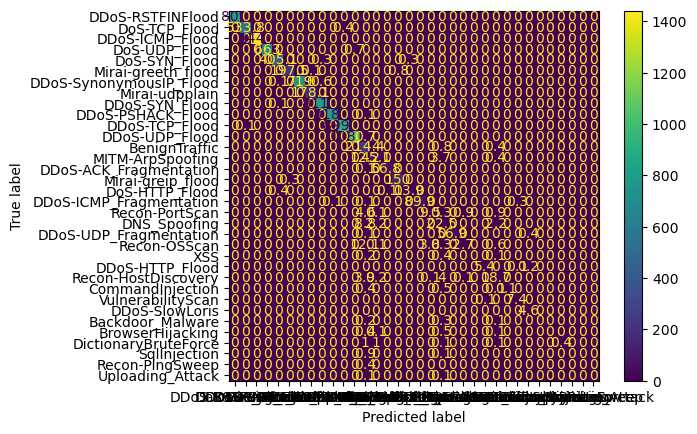

In [53]:
process_confusion_matrix(y_full_test, y_full_pred)

### Optimized

In [54]:
# redo preprocessing
best_preprocessor.fit(X_full_train)
X_full_train = pd.DataFrame(best_preprocessor.transform(X_full_train.copy()), columns=X_full_train.columns)
X_full_test = pd.DataFrame(best_preprocessor.transform(X_full_test.copy()), columns=X_full_test.columns)

# redo feature selection
X_full_train = X_full_train[best_selected_features]
X_full_test = X_full_test[best_selected_features]

# redo data balancing
X_full_train, y_full_train = fit_resample(
    X_full_train, y_full_train, best_over_threshold, best_under_threshold
)

# redo classifier building
model = build_classifier(best_model_params)

In [55]:
%%time
model.fit(X_full_train, y_full_train)
y_full_pred = model.predict(X_full_test)

CPU times: user 19h 1min 50s, sys: 10min 31s, total: 19h 12min 22s
Wall time: 55min 7s


In [56]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.9947534173631909),
                ('Precision (Macro)', 0.9200663538447832),
                ('Precision (Micro)', 0.9947534173631909),
                ('Precision (Weighted)', 0.9948357727578115),
                ('Recall (Macro)', 0.8361829518119723),
                ('Recall (Micro)', 0.9947534173631909),
                ('Recall (Weighted)', 0.9947534173631909),
                ('F1 (Macro)', 0.8640905504168493),
                ('F1 (Micro)', 0.9947534173631909),
                ('F1 (Weighted)', 0.994719945446077)])


In [57]:
process_classification_report(y_full_test, y_full_pred)

                         precision    recall  f1-score   support

       DDoS-RSTFINFlood   0.999996  0.999868  0.999932    809057
          DoS-TCP_Flood   0.999876  0.999326  0.999601    534289
        DDoS-ICMP_Flood   0.999957  0.999941  0.999949   1440101
          DoS-UDP_Flood   0.999754  0.999438  0.999596    663719
          DoS-SYN_Flood   0.999603  0.999238  0.999421    405767
     Mirai-greeth_flood   0.997144  0.998029  0.997586    198373
DDoS-SynonymousIP_Flood   0.999937  0.999704  0.999821    719628
         Mirai-udpplain   0.999747  0.999686  0.999716    178115
         DDoS-SYN_Flood   0.999603  0.999760  0.999682    811838
      DDoS-PSHACK_Flood   0.999998  0.999827  0.999912    818951
         DDoS-TCP_Flood   0.999579  0.999896  0.999737    899533
         DDoS-UDP_Flood   0.999699  0.999786  0.999742   1082457
          BenignTraffic   0.946875  0.940029  0.943439    219639
       MITM-ArpSpoofing   0.864631  0.878151  0.871339     61519
 DDoS-ACK_Fragmentation 

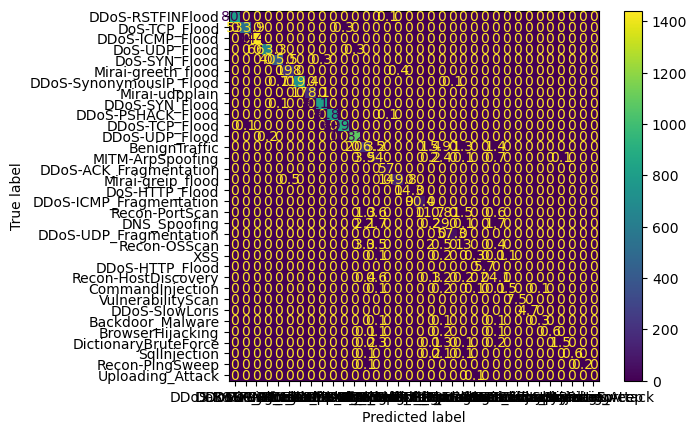

In [58]:
process_confusion_matrix(y_full_test, y_full_pred)